In [1]:
# ============================================================
# 05_error_analysis.ipynb
# Subgroup Performance & Error Analysis
# ============================================================

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

from config import RAW_PATH, PROCESSED_PATH, MODEL_PATH
from data_processing import load_raw_data, clean_data

sns.set(style="whitegrid")
pd.set_option("display.max_columns", 200)

print("RAW_PATH:", RAW_PATH)
print("PROCESSED_PATH:", PROCESSED_PATH)
print("MODEL_PATH:", MODEL_PATH)


RAW_PATH: /Users/loictiemani/Documents/sla-risk-prediction/data/raw/sla_cases.csv
PROCESSED_PATH: /Users/loictiemani/Documents/sla-risk-prediction/data/processed/sla_cases_clean.csv
MODEL_PATH: /Users/loictiemani/Documents/sla-risk-prediction/models/sla_rf_model.pkl


In [2]:
# 1️⃣ Load data
# We need:
# - raw cleaned data to access group columns (country, case_type, processing_stage, office_id, priority)
# - processed encoded data to score the model correctly

df_raw = clean_data(load_raw_data(RAW_PATH))
df_proc = pd.read_csv(PROCESSED_PATH)

TARGET_COL = "sla_breach"

artifact = joblib.load(MODEL_PATH)
if isinstance(artifact, dict):
    model = artifact["model"]
    threshold = artifact.get("threshold", 0.5)
    feature_cols = artifact.get("feature_columns", [c for c in df_proc.columns if c != TARGET_COL])
else:
    model = artifact
    threshold = 0.5
    feature_cols = [c for c in df_proc.columns if c != TARGET_COL]

# Align row order assumption:
# This works if processed data was derived from df_raw without row drops/reordering.
# If you later start filtering rows, store and carry forward case_id to join.
print("Raw rows:", len(df_raw), "Processed rows:", len(df_proc))


Loaded raw dataset: 5000 rows, 15 columns
Raw rows: 5000 Processed rows: 5000


In [3]:

# 2️⃣ Create aligned scoring frame
X = df_proc[feature_cols].copy()
y = df_proc[TARGET_COL].astype(int)

proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else model.predict(X)
pred = (proba >= threshold).astype(int)

scored = df_raw.copy()
scored["predicted_risk"] = proba
scored["predicted_breach"] = pred
scored["actual_breach"] = y.values

scored[["predicted_risk", "predicted_breach", "actual_breach"]].head()


,predicted_risk,predicted_breach,actual_breach
0,0.997595,1,1
1,0.993506,1,1
2,1.000000,1,1
3,0.989607,1,1
4,0.997842,1,1


In [4]:
# 3️⃣ Overall metrics
def metrics_frame(y_true, y_pred, y_proba):
    return {
        "n": len(y_true),
        "breach_rate": float(np.mean(y_true)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_true, y_proba)) if len(np.unique(y_true)) > 1 else np.nan,
    }

overall = metrics_frame(scored["actual_breach"], scored["predicted_breach"], scored["predicted_risk"])
overall



{'n': 5000,
 'breach_rate': 0.9258,
 'precision': 1.0,
 'recall': 0.9081875135018362,
 'f1': 0.951884976791577,
 'roc_auc': 0.9986811144321018}

In [5]:
# 4️⃣ Subgroup metrics helper
GROUP_COLS = ["country", "case_type", "processing_stage", "office_id"]

if "priority" in scored.columns:
    GROUP_COLS.append("priority")

def subgroup_metrics(df, group_col, min_n=50):
    rows = []
    for g, sub in df.groupby(group_col):
        if len(sub) < min_n:
            continue
        m = metrics_frame(sub["actual_breach"], sub["predicted_breach"], sub["predicted_risk"])
        m[group_col] = g
        rows.append(m)
    out = pd.DataFrame(rows).sort_values("recall", ascending=True)
    return out

for col in GROUP_COLS:
    print("\n=== Subgroup metrics by", col, "===")
    display(subgroup_metrics(scored, col, min_n=60).head(15))



=== Subgroup metrics by country ===


,n,breach_rate,precision,recall,f1,roc_auc,country
2,584,0.919521,1.0,0.886406,0.939783,0.998257,DE
4,1518,0.925560,1.0,0.907473,0.951493,0.998262,US
0,776,0.930412,1.0,0.909972,0.952864,0.999538,AU
3,875,0.926857,1.0,0.913687,0.954897,0.999229,UK
1,1247,0.925421,1.0,0.914211,0.955183,0.998546,CA



=== Subgroup metrics by case_type ===


,n,breach_rate,precision,recall,f1,roc_auc,case_type
0,500,0.346000,1.0,0.017341,0.034091,0.990720,PR Application
5,1134,0.968254,1.0,0.833333,0.909091,0.997495,Work Permit
2,972,0.994856,1.0,0.953464,0.976178,0.998966,Relocation
4,904,0.996681,1.0,0.982242,0.991041,0.994821,Visa Renewal
3,922,1.000000,1.0,0.990239,0.995095,NaN,Tax
1,568,1.000000,1.0,0.996479,0.998236,NaN,Payroll



=== Subgroup metrics by processing_stage ===


,n,breach_rate,precision,recall,f1,roc_auc,processing_stage
3,1294,0.962906,1.0,0.880417,0.936406,0.998713,Government Review
4,744,0.904570,1.0,0.910847,0.953344,0.998054,Intake
0,493,0.894523,1.0,0.911565,0.953737,0.999782,Closure
1,778,0.944730,1.0,0.915646,0.955966,1.000000,Decision
5,770,0.897403,1.0,0.920405,0.958553,0.997527,Submission
2,921,0.915309,1.0,0.928826,0.963100,0.999498,Documentation



=== Subgroup metrics by office_id ===


,n,breach_rate,precision,recall,f1,roc_auc,office_id
14,286,0.909091,1.0,0.884615,0.938776,0.997781,114
3,259,0.926641,1.0,0.887500,0.940397,1.000000,103
19,245,0.946939,1.0,0.887931,0.940639,0.999668,119
18,251,0.940239,1.0,0.889831,0.941704,0.999718,118
1,252,0.916667,1.0,0.891775,0.942792,0.994228,101
2,272,0.900735,1.0,0.897959,0.946237,1.000000,102
11,250,0.928000,1.0,0.900862,0.947846,0.996169,111
15,221,0.932127,1.0,0.902913,0.948980,0.994822,115
17,231,0.917749,1.0,0.905660,0.950495,0.998014,117
16,299,0.933110,1.0,0.906810,0.951128,0.999462,116



=== Subgroup metrics by priority ===


,n,breach_rate,precision,recall,f1,roc_auc,priority
0,3854,0.916969,1.0,0.906055,0.950713,0.998491,Normal
1,1146,0.955497,1.0,0.915068,0.955651,0.999481,Urgent


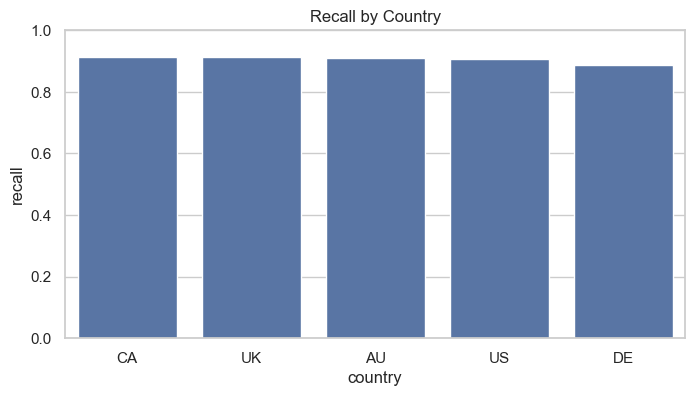

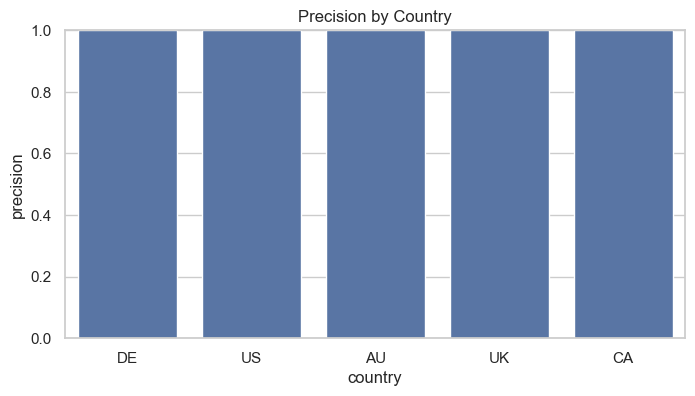

In [6]:
# 5️⃣ Visualize subgroup recall/precision (example: country)
country_metrics = subgroup_metrics(scored, "country", min_n=60)

plt.figure(figsize=(8,4))
sns.barplot(x="country", y="recall", data=country_metrics.sort_values("recall", ascending=False))
plt.title("Recall by Country")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x="country", y="precision", data=country_metrics.sort_values("precision", ascending=False))
plt.title("Precision by Country")
plt.ylim(0, 1)
plt.show()


In [7]:
# 6️⃣ Error slices: where are most false negatives?
# False negatives are missed risky cases (worst for early warning)

scored["error_type"] = "TN/TP"
scored.loc[(scored["actual_breach"] == 1) & (scored["predicted_breach"] == 0), "error_type"] = "FN"
scored.loc[(scored["actual_breach"] == 0) & (scored["predicted_breach"] == 1), "error_type"] = "FP"
scored.loc[(scored["actual_breach"] == 1) & (scored["predicted_breach"] == 1), "error_type"] = "TP"
scored.loc[(scored["actual_breach"] == 0) & (scored["predicted_breach"] == 0), "error_type"] = "TN"

fn = scored[scored["error_type"] == "FN"]
fp = scored[scored["error_type"] == "FP"]

print("FN count:", len(fn), "FP count:", len(fp))

for col in ["country", "case_type", "processing_stage"]:
    print("\nTop FN rates by", col)
    tmp = scored.groupby(col).apply(lambda x: np.mean(x["error_type"] == "FN")).sort_values(ascending=False)
    display(tmp.head(10).to_frame("FN_rate"))


FN count: 425 FP count: 0

Top FN rates by country


/var/folders/tv/_dfrh8cx7_q96xxc1d_m787m0000gn/T/ipykernel_57322/3106588960.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = scored.groupby(col).apply(lambda x: np.mean(x["error_type"] == "FN")).sort_values(ascending=False)


,FN_rate
country,
DE,0.104452
US,0.085639
AU,0.083763
UK,0.080000
CA,0.079391



Top FN rates by case_type


/var/folders/tv/_dfrh8cx7_q96xxc1d_m787m0000gn/T/ipykernel_57322/3106588960.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = scored.groupby(col).apply(lambda x: np.mean(x["error_type"] == "FN")).sort_values(ascending=False)


,FN_rate
case_type,
PR Application,0.340000
Work Permit,0.161376
Relocation,0.046296
Visa Renewal,0.017699
Tax,0.009761
Payroll,0.003521



Top FN rates by processing_stage


/var/folders/tv/_dfrh8cx7_q96xxc1d_m787m0000gn/T/ipykernel_57322/3106588960.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = scored.groupby(col).apply(lambda x: np.mean(x["error_type"] == "FN")).sort_values(ascending=False)


,FN_rate
processing_stage,
Government Review,0.115147
Intake,0.080645
Decision,0.079692
Closure,0.079108
Submission,0.071429
Documentation,0.065147


In [8]:
# 7️⃣ Responsible AI note (template text you can paste into README)
responsible_ai_notes = """
Responsible AI / Fairness Note:
This model is intended for decision support and should be used with human oversight.
Performance can vary by subgroup (e.g., country, case type, processing stage, office).
Before deployment, subgroup metrics should be monitored to avoid systematically under-flagging
certain workflows or regions (false negatives) or over-flagging others (false positives).
Thresholds may be tuned to operational priorities, and periodic retraining is recommended.
"""
print(responsible_ai_notes)




Responsible AI / Fairness Note:
This model is intended for decision support and should be used with human oversight.
Performance can vary by subgroup (e.g., country, case type, processing stage, office).
Before deployment, subgroup metrics should be monitored to avoid systematically under-flagging
certain workflows or regions (false negatives) or over-flagging others (false positives).
Thresholds may be tuned to operational priorities, and periodic retraining is recommended.

